# Topic modeling visualization

In [3]:
import pandas as pd; print("Loaded: pandas",pd.__version__)

import re; print("Loaded: re",re.__version__,"(RegEx module)")
from nltk.tokenize import sent_tokenize as sbd; print("Loaded: sent_tokenize as sbd") # sbd=Sentence Boundary Disambiguation=SBD
import time as t; print("Loaded: time")

Loaded: pandas 0.23.4
Loaded: re 2.2.1 (RegEx module)
Loaded: sent_tokenize as sbd
Loaded: time


In [2]:
%%time
df_full = pd.read_csv('data/train.csv', sep=",", encoding="utf-8", quotechar='"')
df_full = df_full[~df_full['ReviewText'].isnull()]

Wall time: 12.4 s


In [4]:
df_train = df_full[df_full['Rating'] == 5].sample(n = 5000, random_state = 15)

df_train = df_train.copy()

# Remove index used in df_train from df_test
df_test = df_full.drop(labels = df_train.index)

In [5]:
df=df_train

In [6]:
df_train.head()

ReviewText  Rating
1013874  And I like that.  The product page explains in...       5
1227387  This is the 2nd case we bought for this tablet...       5
1238169  The Kingston Digital Traveler is a smart, well...       5
760296   Cable was what I expected.  Good quality for a...       5
75902    Expensive but does the job flawlessly.  I have...       5

In [7]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're','edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 
                   'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take','way','low', 'however','give',
                   'last','define', 'keep','still','increase','survey','slow','swim','instead','meet', 'old','usage','better','vmware','show','hour','survey','time','put','sddc',
                   'agent','part','little','move','appear','staff','set','always','offer','consider','meet','old','state','option', 'hour', 'disapoointing','employee','dell',
                   'emc','survey','legacy','increase','however','work','year','leave','change','people','time','start','work','service','lose','support','customer','opportunity',
                   'team','meet','new','next','level','organization','hard','senior','report','reject','huge','company','high','bad','day','well','understand','come','request',
                  'feel', 'reason', 'provide', 'system', 'open', 'improve', 'head', 'member','enough','hire','save','ask','due','focus','tell','come','request',
                   'site','back','give','related','much','securework','datum','disappointing','side','pivitol','eye','eliminate','interaction','require',
                   'external', 'soon', 'block', 'rubbish','apply', 'entire', 'vision', 'feedback','clear', 'issue', 'drive', 'already', 'first','announce',
                   'remunerate','find','avoid','carr','mention', 'really','product','share','delight','information','slide','help','barb',
                   'question','threat','current','grow','miss','strength','weakness','solve','future','result','core','material',
                  'hone', 'lane','especially', 'vs','significant', 'single', 'cause', 'unit', 'strategic', 'hold','great','sometimes', 'decision',
                  'bring', 'tier','group', 'basic','topic', 'different', 'add', 'example', 'date', 'general','standard','point', 'case',
                  'big', 'discussion','sale', 'sds','frs', 'top', 'global', 'value', 'sell', 'talk','gain','id', 'call','align',
                  'thing', 'individual','success', 'offering','csat', 'direct', 'approach', 'visibility', 'access', 'strategy','cascade','plan', 'concern',
                  'receive', 'message','update', 'helpful','contribute', 'role', 'link', 'presentation', 'forward', 'meeting','business','goal', 'priority',
                   'align', 'able','connect', 'achieve','contribute', 'role', 'link', 'presentation', 'forward', 'meeting','business','goal', 'priority',
                     'follow', 'large','important', 'highlight','content', 'relate', 'fy', 'looking_forward', 'alignment', 'job','hear','understanding', 'priority',
                    'consistency', 'initiative','direction', 'specific','execute', 'pillar', 'similar', 'delivery', 'alignment', 'job','hear','understanding', 'priority',
                    'solution', 'large','important', 'end','answer', 'directly', 'discuss', 'looking_forward', 'alignment', 'job','hear','understanding', 'priority',
                    'growth', 'program','view', 'challenge','content', 'relate', 'fy', 'conversation', 'lead', 'tie','exercise','map', 'win','clarity',
                    'process', 'renewal','measure', 'deliver','doug', 'place', 'rep', 'something', 'joint', 'picture','enable','interactive', 'term',
                    'session','detail','model','regard','field','stay','base','video','excellent','messaging','format','execution','daily','nothing','org',
                    'impact','consistent','ensure','idea','everyone','believe','roll','live','additional','action','allow','like','ahead','play','long','common','welcome','manager',
                   'look', 'reaction','reduction', 'event','position', 'public', 'hall', 'town', 'insight', 'effort','enable','interactive', 'term',
                   'emea', 'bit','basis', 'productive','operate', 'second', 'rep', 'past', 'flow', 'picture','enable','interactive', 'term',
                   'include','com', 'overall','continue', 'key','schmitt','bill','dellemc','xsab','apj','paint','manage','sp','expect','concerned',
                  'useful','create', 'correct','enjoy', 'exist','input'])
    


%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [8]:
# Import Dataset

#print(df.shape)  
#df.head()

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.ReviewText.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [[the', 'floor', 'moves', 'the', 'population', 'density', 'is', 'high', 'the', 'room', 'air', 'conditioning', 'of', 'the', 'dominant', 'is', 'weak', 'and', 'the', 'toilet', 'is', 'crowded', 'and', 'the', 'office', 'of', 'æœ', 'on']]

[['and', 'like', 'that', 'the', 'product', 'page', 'explains', 'in', 'detail', 'what', 'this', 'little', 'router', 'will', 'and', 'will', 'not', 'do', 'the', 'comparison', 'table', 'tells', 'you', 'what', 'you', 'are', 'getting', 'for', 'your', 'money', 'and', 'also', 'tells', 'you', 'what', 'you', 'can', 'get', 'for', 'more', 'money', 'for', 'person', 'like', 'me', 'who', 'never', 'used', 'router', 'before', 'the', 'comparison', 'table', 'gave', 'me', 'lot', 'of', 'info', 'im', 'always', 'gun', 'shy', 'of', 'software', 'and', 'hardware', 'setups', 'this', 'setup', 'was', 'super', 'easy', 'if', 'you', 'do', 'your', 'homework', 'and', 'read', 'the', 'product', 'page', 'carefully', 'and', 'decide', 'this', 'router', 'suits', 'your', 'needs', 'then', 'dont', 'see', 'how', 'you', 'can', 'go', 'wrong', 'by', 'putting', 'it', 'in', 'your', 'shopping', 'cart']]


In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.041*"cable" + 0.032*"usb" + 0.028*"quality" + 0.021*"laptop" + '
  '0.019*"device" + 0.018*"power" + 0.018*"sound" + 0.015*"tv" + 0.014*"plug" '
  '+ 0.013*"speaker"'),
 (1,
  '0.026*"lens" + 0.017*"light" + 0.016*"computer" + 0.016*"small" + '
  '0.015*"fit" + 0.014*"mount" + 0.013*"cover" + 0.012*"speed" + 0.012*"fast" '
  '+ 0.010*"color"'),
 (2,
  '0.037*"buy" + 0.026*"camera" + 0.022*"price" + 0.018*"purchase" + '
  '0.015*"battery" + 0.015*"love" + 0.012*"cheap" + 0.010*"remote" + '
  '0.010*"feature" + 0.009*"recommend"'),
 (3,
  '0.023*"card" + 0.016*"screen" + 0.013*"monitor" + 0.012*"order" + '
  '0.011*"read" + 0.010*"ipad" + 0.010*"brand" + 0.010*"window" + '
  '0.009*"keyboard" + 0.009*"game"')]


In [12]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.4289   
1            1             2.0              0.5640   
2            2             1.0              0.6341   
3            3             0.0              0.8873   
4            4             1.0              0.6080   
5            5             2.0              0.4513   
6            6             0.0              0.4774   
7            7             0.0              0.6946   
8            8             0.0              0.4864   
9            9             2.0              0.7204   

                                            Keywords  \
0  card, screen, monitor, order, read, ipad, bran...   
1  buy, camera, price, purchase, battery, love, c...   
2  lens, light, computer, small, fit, mount, cove...   
3  cable, usb, quality, laptop, device, power, so...   
4  lens, light, computer, small, fit, mount, cove...   
5  buy, camera, price, purchase, battery, love, c...   
6  cable, usb, quality, laptop, device, power, so...   
7  cable, usb, quality, laptop, device, power, so...   
8  cable, usb, quality, laptop, device, power, so...   
9  buy, camera, price, purchase, battery, love, c...   

                                                Text  
0  [page, explain, router, comparison, table, mon...  
1  [buy, tablet, far, superior, fit, tablet, clea...  
2  [kingston, digital, traveler, smart, design, s...  
3  [cable, quality, price, cable, device, recommend]  
4  [expensive, flawlessly, nikon, lens, literally...  
5  [hop, price, worried, theft, purchase, enclose...  
6  [buy, wife, android, phone, walk, listen, musi...  
7  [search, perfect, bluetooth, stereo, headset, ...  
8   [price, power_supply, quick, fix, laptop, quick]  
9  [purchase, original, samsung, hotel, room, buy...

In [13]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(1000)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9532   
1        1.0              0.9609   
2        2.0              0.9500   
3        3.0              0.9051   

                                                                         Keywords  \
0            cable, usb, quality, laptop, device, power, sound, tv, plug, speaker   
1             lens, light, computer, small, fit, mount, cover, speed, fast, color   
2  buy, camera, price, purchase, battery, love, cheap, remote, feature, recommend   
3         card, screen, monitor, order, read, ipad, brand, window, keyboard, game   

                                                                                   Representative Text  
0  [btry, advetis, life, recharge, prrfect, cordless, phone, wear, cordle, phone, supper, recharge,...  
1  [utilizo, este, tipo, conector, para, instalacione, domestica, calidad, confiabilidad, la, marca...  
2  [purchase, panasonic, adorama, everything, legitimate, far, everything, printing, battery, match...  
3                                                      [temperature, gpu, nvidia, gtx, ti, bore, cool]

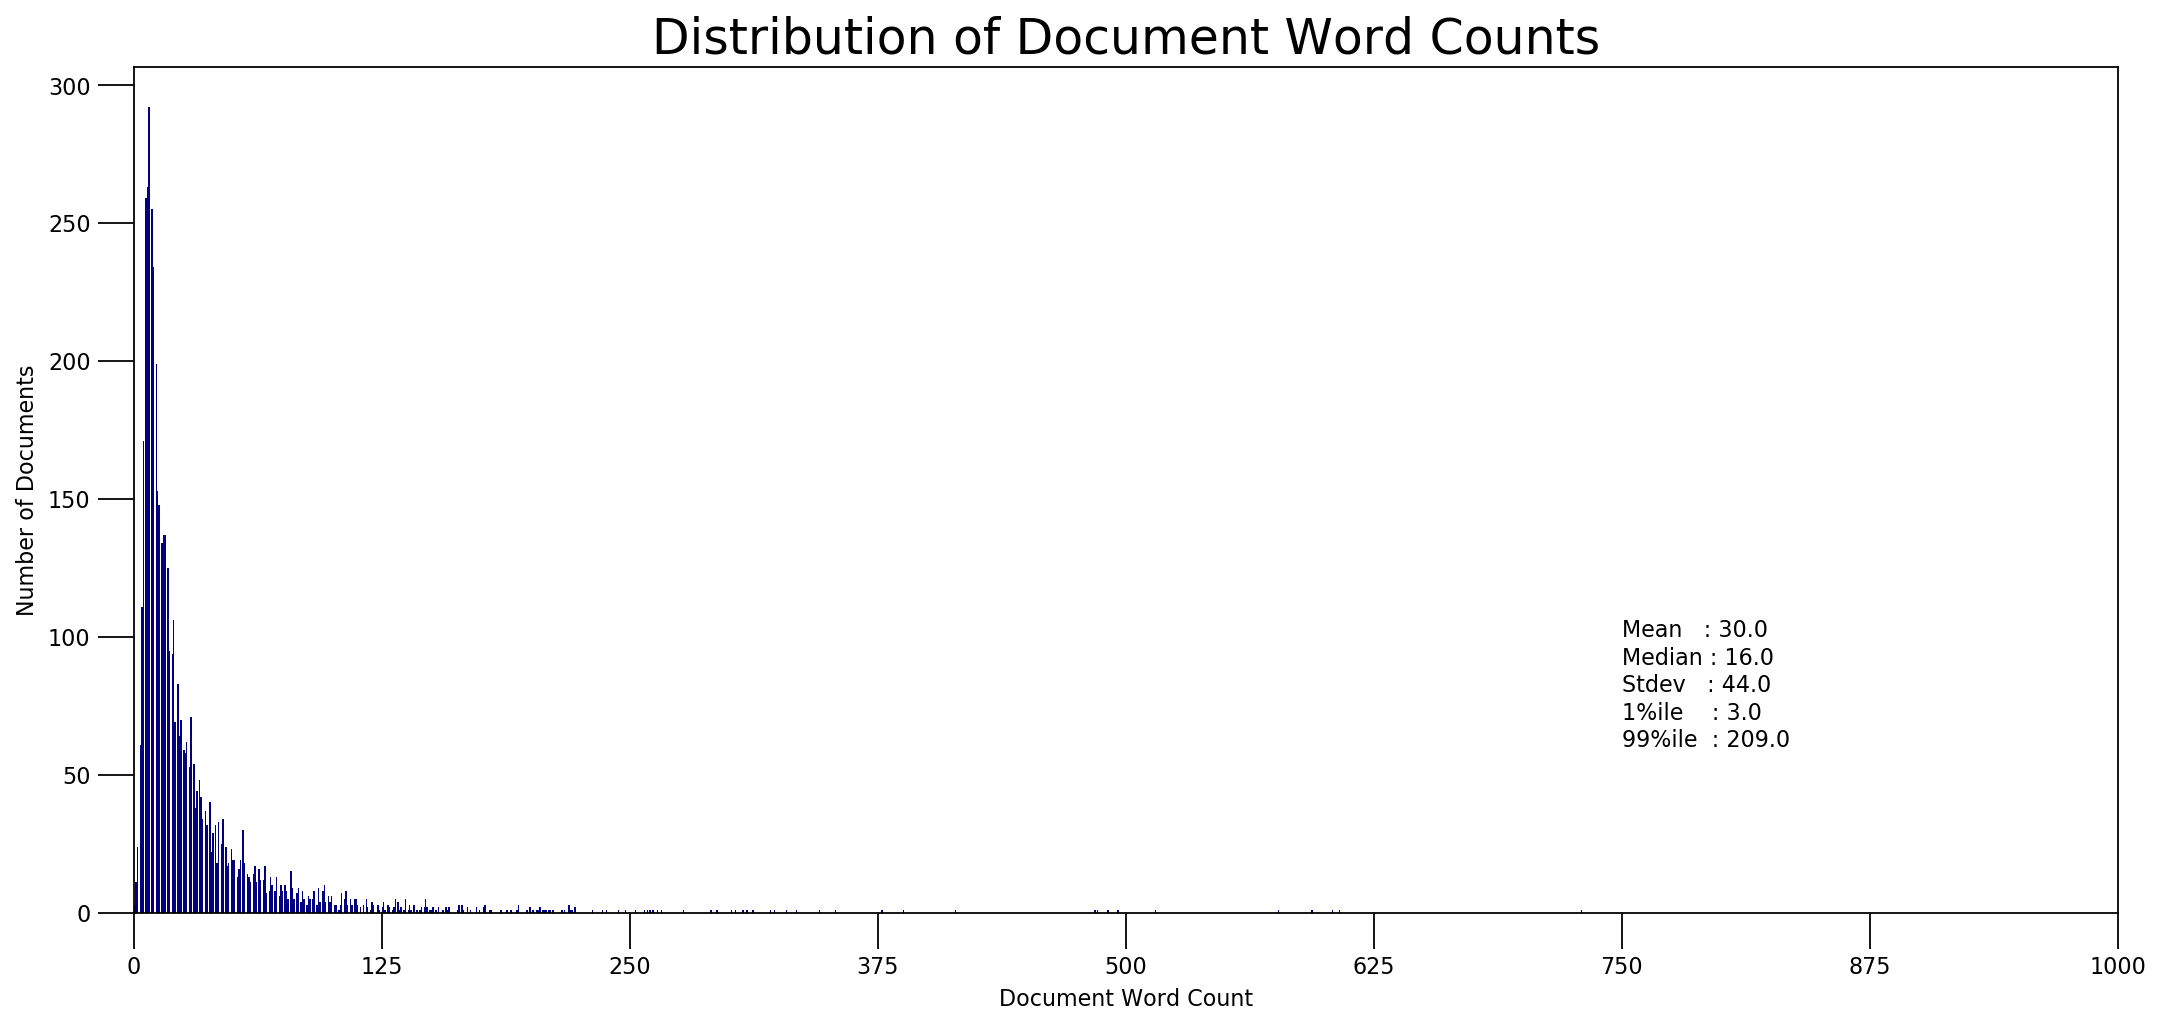

In [14]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Users\nagorb\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


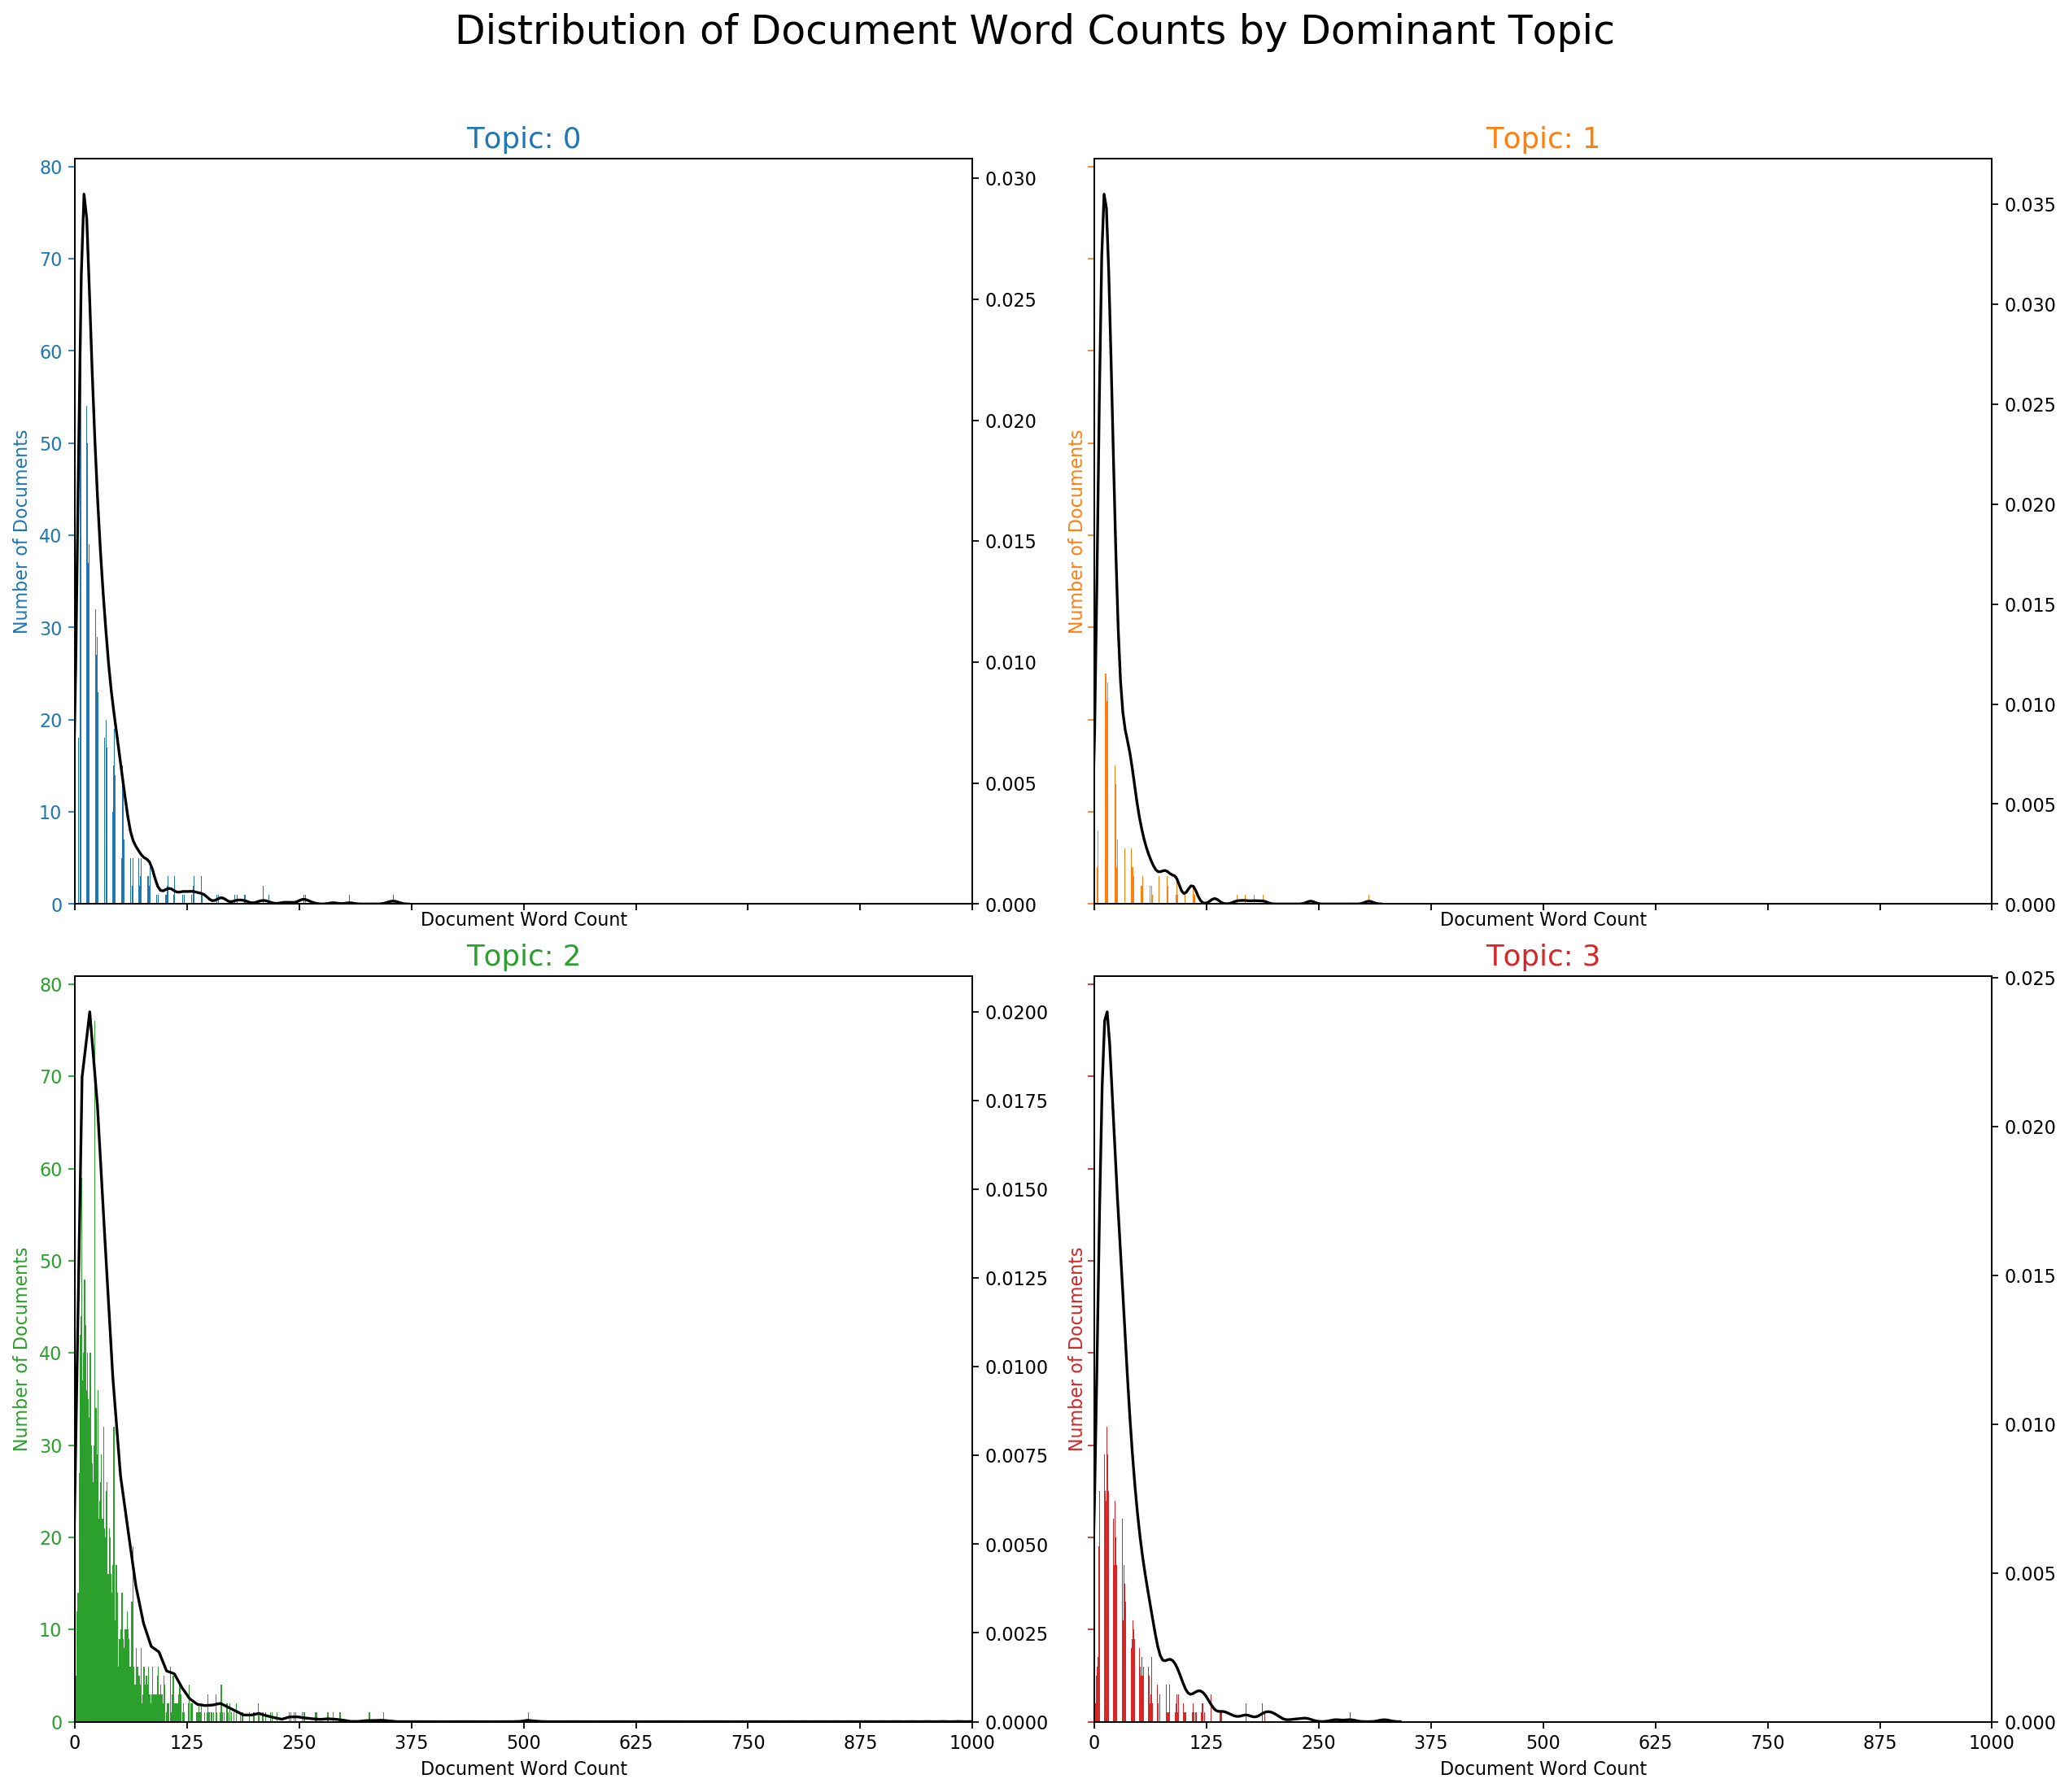

In [29]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

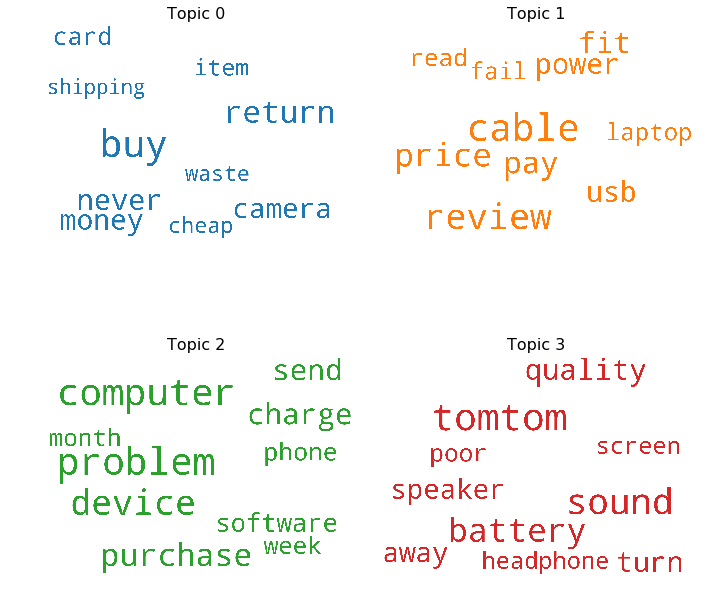

In [30]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

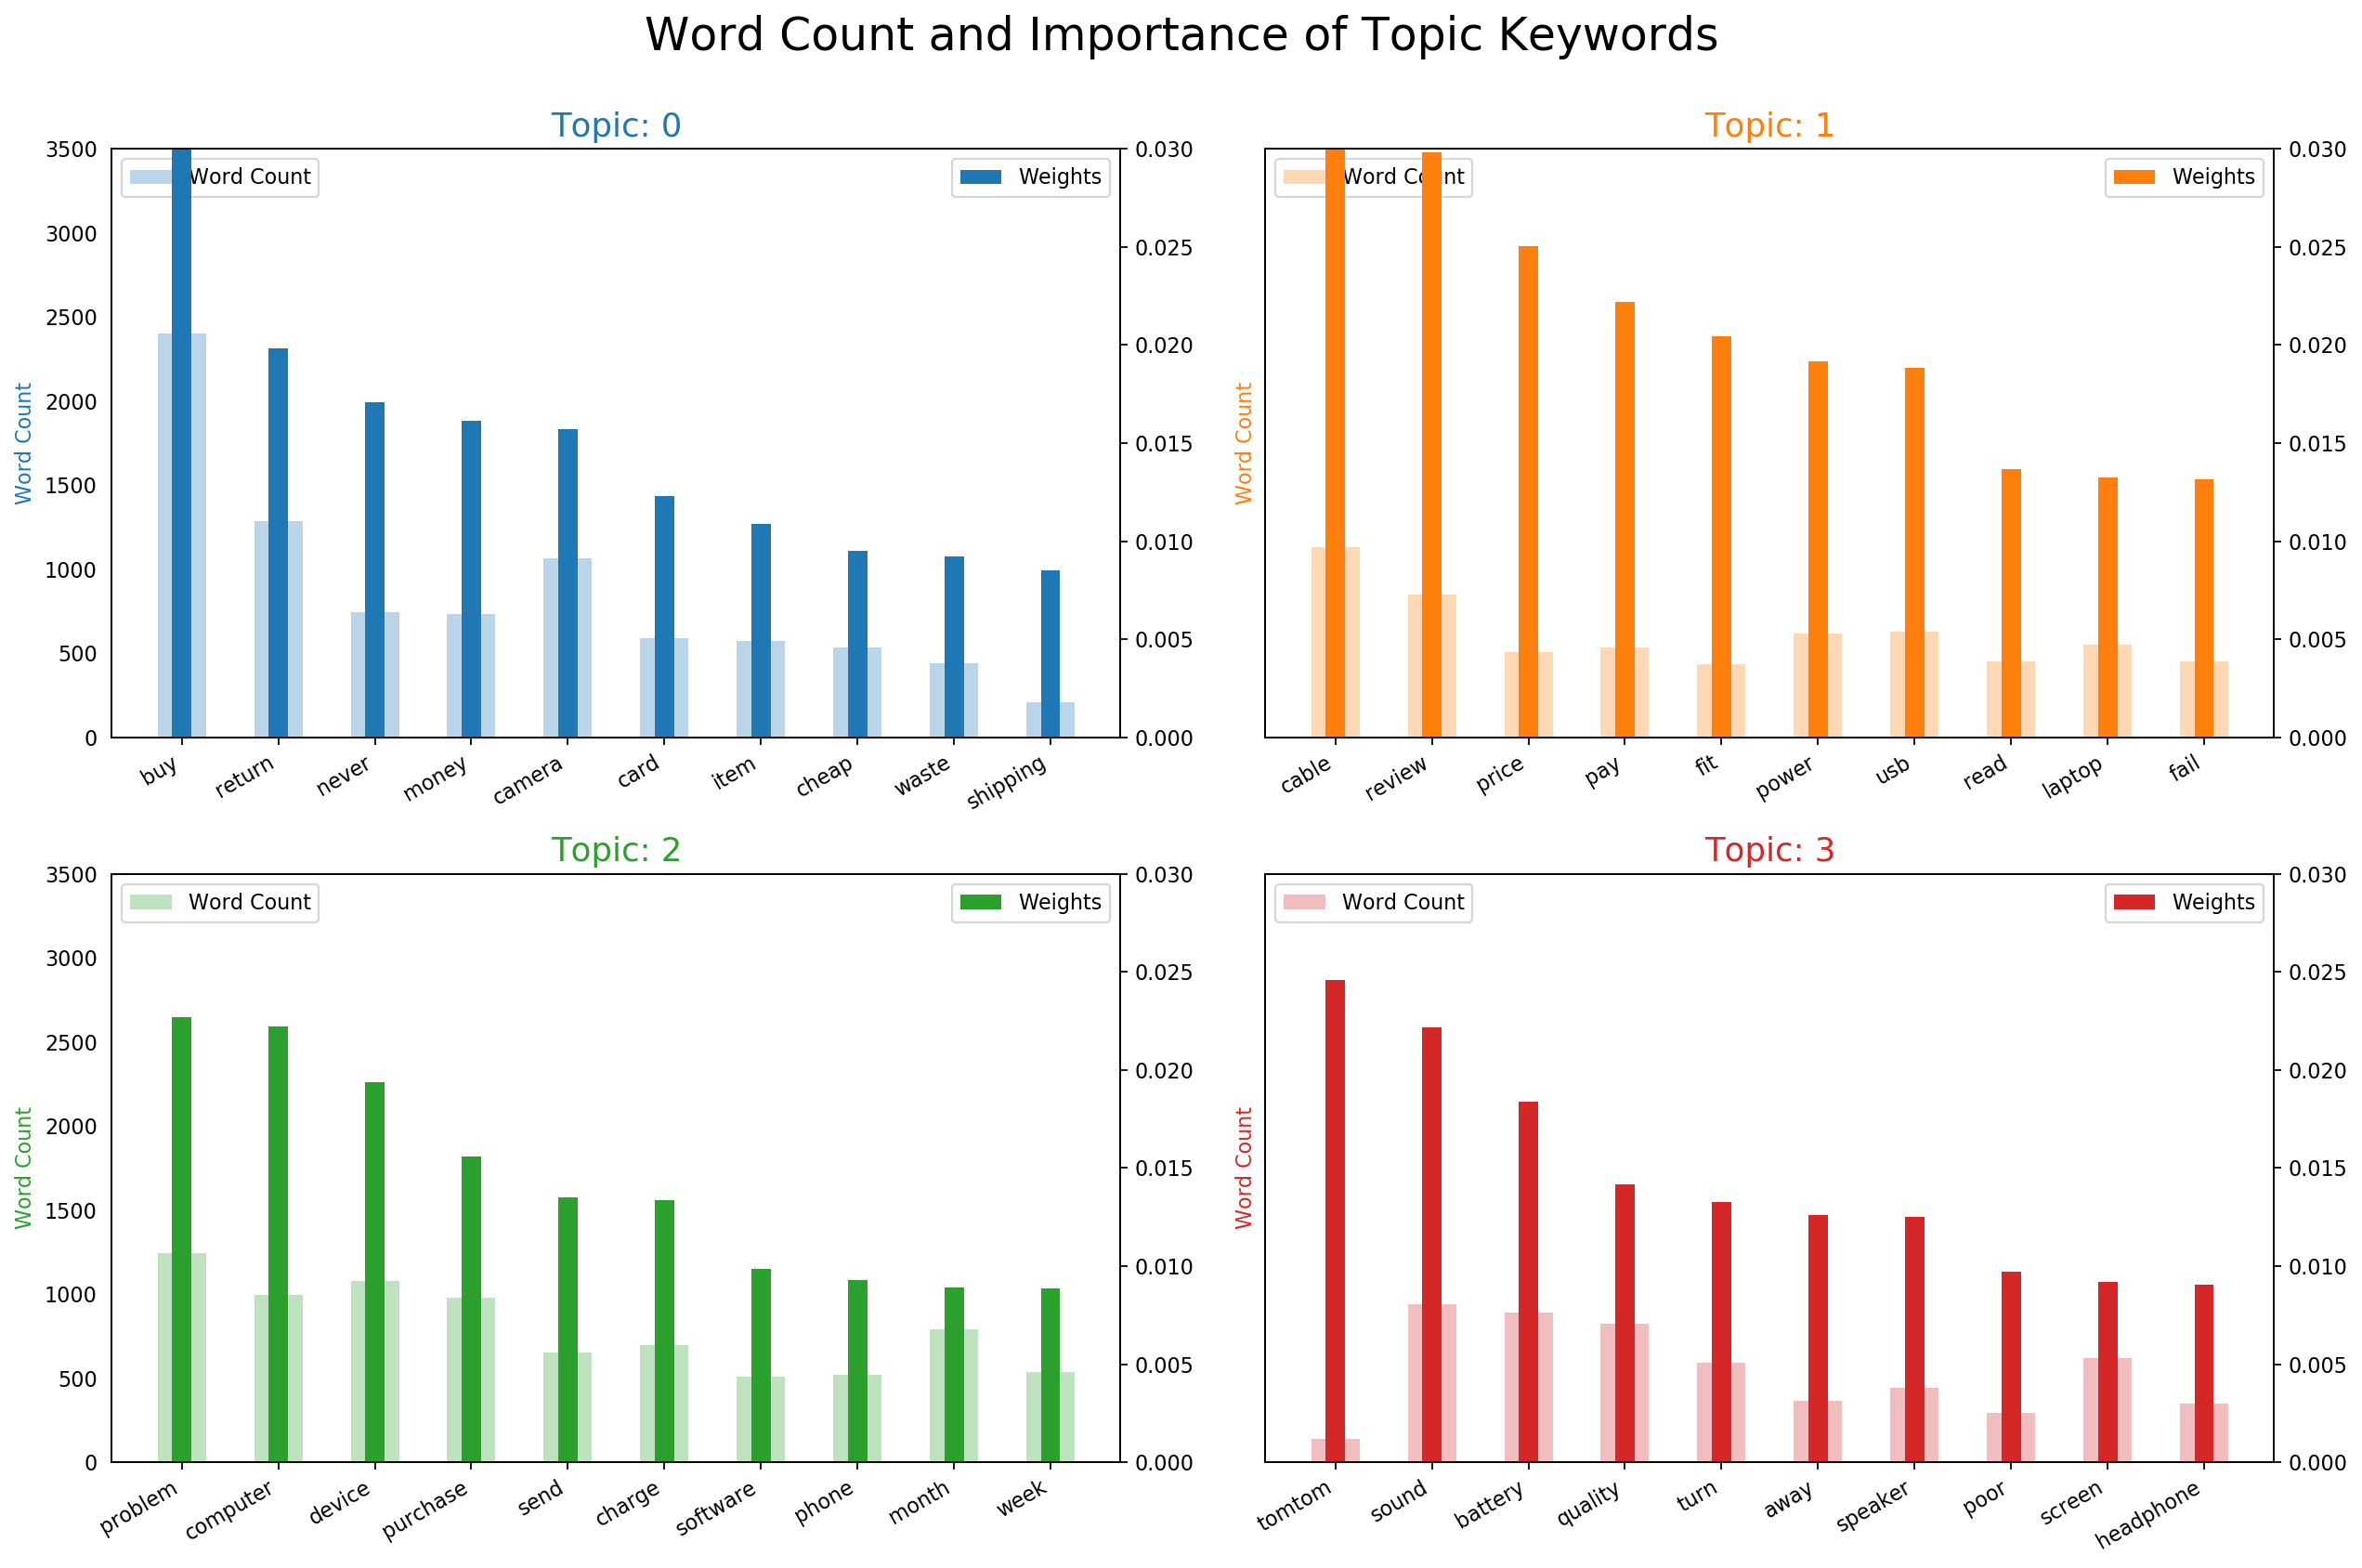

In [31]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [32]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 136):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()   

In [33]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

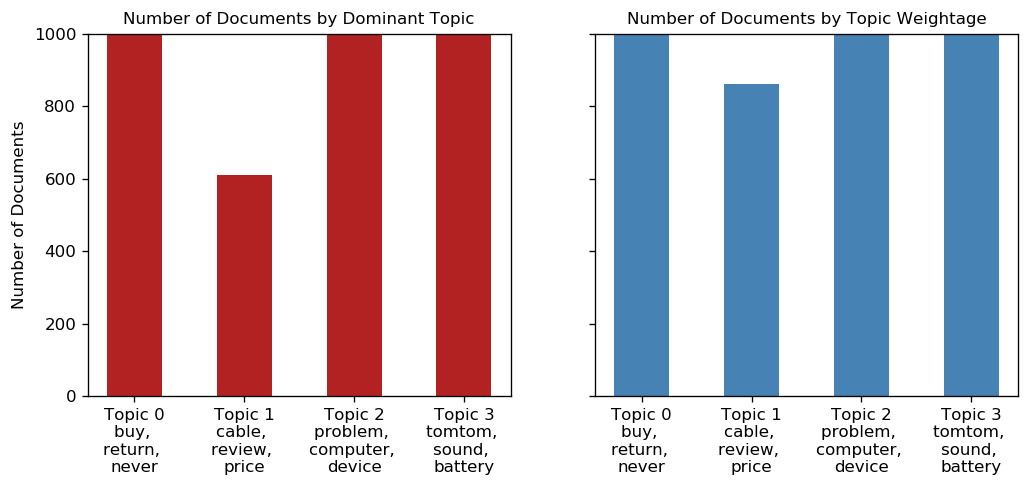

In [34]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [35]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4493 samples in 0.009s...
[t-SNE] Computed neighbors for 4493 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4493
[t-SNE] Computed conditional probabilities for sample 2000 / 4493
[t-SNE] Computed conditional probabilities for sample 3000 / 4493
[t-SNE] Computed conditional probabilities for sample 4000 / 4493
[t-SNE] Computed conditional probabilities for sample 4493 / 4493
[t-SNE] Mean sigma: 0.042653
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.797729
[t-SNE] KL divergence after 1000 iterations: 1.079899


Loading BokehJS ...

In [36]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\nagorb\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.263994 -0.202866       1        1  32.335697
0     -0.084149  0.250637       2        1  28.593838
3      0.262185 -0.160919       3        1  23.041771
1      0.085958  0.113148       4        1  16.028696, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
524   Default   936.000000        cable   936.000000  30.0000  30.0000
27    Default   825.000000       review   825.000000  29.0000  29.0000
3825  Default   977.000000       tomtom   977.000000  28.0000  28.0000
49    Default  1268.000000      problem  1268.000000  27.0000  27.0000
86    Default  1239.000000     computer  1239.000000  26.0000  26.0000
278   Default   881.000000        sound   881.000000  25.0000  25.0000
48    Default   693.000000        price   693.000000  24.0000  24.0000
91    Default  1082.000000       device  1082.000000  23.0000  23.0000
47    Default   615.000000          pay   615.000000  22.0000  22.0000
208   Default   731.000000      battery   731.000000  21.0000  21.0000
4     Default  2102.000000          buy  2102.000000  20.0000  20.0000
46    Default   843.000000        never   843.000000  19.0000  19.0000
135   Default   565.000000          fit   565.000000  18.0000  18.0000
105   Default   870.000000     purchase   870.000000  17.0000  17.0000
144   Default   776.000000       camera   776.000000  16.0000  16.0000
37    Default   521.000000          usb   521.000000  15.0000  15.0000
98    Default   814.000000        money   814.000000  14.0000  14.0000
24    Default   650.000000        power   650.000000  13.0000  13.0000
118   Default   745.000000       charge   745.000000  12.0000  12.0000
59    Default   563.000000      quality   563.000000  11.0000  11.0000
26    Default  1202.000000       return  1202.000000  10.0000  10.0000
197   Default   527.000000         turn   527.000000   9.0000   9.0000
136   Default   607.000000         card   607.000000   8.0000   8.0000
284   Default   502.000000         away   502.000000   7.0000   7.0000
76    Default   777.000000         send   777.000000   6.0000   6.0000
957   Default   497.000000      speaker   497.000000   5.0000   5.0000
22    Default   827.000000         plug   827.000000   4.0000   4.0000
25    Default   379.000000         read   379.000000   3.0000   3.0000
17    Default   367.000000       laptop   367.000000   2.0000   2.0000
64    Default   363.000000         fail   363.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2      Topic4   360.992493          box   361.738037   1.8287  -4.3387
64     Topic4   363.188232         fail   363.951019   1.8287  -4.3326
522    Topic4   305.366028      adapter   306.091125   1.8284  -4.5060
21     Topic4   273.389618      plastic   274.134094   1.8281  -4.6166
268    Topic4   288.177582         dock   289.051300   1.8278  -4.5639
42     Topic4   252.896454         less   253.702560   1.8276  -4.6945
3404   Topic4   254.460846         asus   255.273193   1.8276  -4.6884
840    Topic4   231.746994       seller   232.501938   1.8275  -4.7819
1910   Topic4   217.850449          hub   218.571640   1.8275  -4.8437
1551   Topic4   220.677490      monitor   221.451889   1.8273  -4.8308
8      Topic4   204.769791        cover   205.533752   1.8271  -4.9056
375    Topic4   195.199219       outlet   195.946503   1.8270  -4.9535
6      Topic4   174.184357    connector   174.898087   1.8267  -5.0674
2014   Topic4   178.394974        screw   179.186920   1.8264  -5.0435
1197   Topic4   151.714371  motherboard   152.482193   1.8257  -5.2055
1719   Topic4   137.229111         disk   137.942078   1.8256  -5.3059
13     Topic4   130.276627          fan   130.999756   1.8253  -5.3579
393    Topic4   126.908234  description   127.658615   1.8249  -5.3841
285    Topic

In [37]:
df_dominant_topic.to_csv("data/string_positive1.csv")

In [38]:
df_dominant_topic

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0             1.0              0.6886   
1               1             1.0              0.5111   
2               2             0.0              0.3945   
3               3             2.0              0.7055   
4               4             2.0              0.9825   
5               5             2.0              0.8300   
6               6             1.0              0.4548   
7               7             0.0              0.6992   
8               8             0.0              0.9687   
9               9             0.0              0.7587   
10             10             3.0              0.4778   
11             11             3.0              0.5822   
12             12             2.0              0.5323   
13             13             3.0              0.7933   
14             14             3.0              0.7293   
15             15             3.0              0.6702   
16             16             3.0              0.4019   
17             17             3.0              0.5668   
18             18             3.0              0.4159   
19             19             1.0              0.5410   
20             20             0.0              0.3824   
21             21             2.0              0.7484   
22             22             0.0              0.7329   
23             23             3.0              0.7260   
24             24             0.0              0.5485   
25             25             0.0              0.4170   
26             26             0.0              0.8739   
27             27             1.0              0.4242   
28             28             0.0              0.5794   
29             29             1.0              0.4241   
...           ...             ...                 ...   
4970         4970             2.0              0.5938   
4971         4971             0.0              0.8056   
4972         4972             3.0              0.3319   
4973         4973             0.0              0.4930   
4974         4974             0.0              0.4374   
4975         4975             2.0              0.4506   
4976         4976             0.0              0.4071   
4977         4977             3.0              0.4707   
4978         4978             3.0              0.5863   
4979         4979             0.0              0.6239   
4980         4980             0.0              0.5454   
4981         4981             0.0              0.4866   
4982         4982             0.0              0.5237   
4983         4983             0.0              0.4781   
4984         4984             3.0              0.4249   
4985         4985             2.0              0.3504   
4986         4986             3.0              0.4299   
4987         4987             0.0              0.4864   
4988         4988             0.0              0.3212   
4989         4989             1.0              0.3622   
4990         4990             0.0              0.5986   
4991         4991             0.0              0.4243   
4992         4992             0.0              0.7027   
4993         4993             2.0              0.6248   
4994         4994             2.0              0.7357   
4995         4995             0.0              0.5800   
4996         4996             2.0              0.5494   
4997         4997             2.0              0.5288   
4998         4998             2.0              0.4131   
4999         4999             3.0              0.6072   

                                                                             Keywords  \
0                      cable, review, price, pay, fit, power, usb, read, laptop, fail   
1                      cable, review, price, pay, fit, power, usb, read, laptop, fail   
2               buy, return, never, money, camera, card, item, cheap, waste, shipping   
3     problem, computer, device, purchase, send, charge, software, phone, month, week   
4     problem, computer, d

In [39]:
import os

from os import path
from wordcloud import WordCloud

In [40]:
print(data_ready)

[['eforcity', 'laptop', 'chill', 'pad', 'dual', 'fan', 'notebook', 'cooler', 'extremely', 'poorly', 'build', 'box', 'usb', 'connector', 'plug', 'thus', 'insert', 'connector', 'power', 'fan', 'connector', 'silver', 'spray', 'fully', 'cover', 'black', 'uncover', 'area', 'sticker', 'lift', 'silver', 'sticker', 'cover', 'join', 'plastic', 'buy', 'read', 'review', 'suck', 'waste', 'return', 'thinking', 'stand', 'eventually', 'trash'], ['month', 'trash', 'connector', 'flimsy', 'snap', 'completely', 'board', 'routine', 'wear', 'tear', 'pay', 'less', 'list', 'price', 'selling', 'never', 'problem', 'mb', 'sturdy'], ['tow', 'cheap', 'quality', 'plastic', 'cap', 'broke', 'recommend', 'buy', 'substantial'], ['wife', 'week', 'build', 'software', 'let', 'eject', 'safely', 'uninstall', 'reinstall', 'software', 'eject', 'safely', 'yank', 'risky', 'secured', 'partition', 'ready', 'prime', 'lexar', 'tech', 'send', 'useless', 'file', 'tech', 'speak', 'fail', 'send', 'unale', 'fix', 'problem'], ['experien

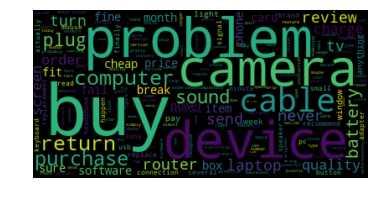

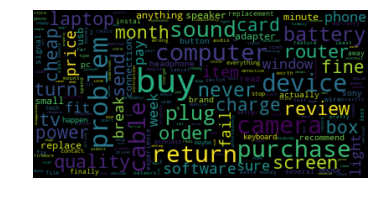

In [42]:

import os

from os import path
from wordcloud import WordCloud

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, 'dataready.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()